<a href="https://colab.research.google.com/github/quokka-works/Satellite_Image_Classification/blob/main/Satellite_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prequisties**

In [ ]:
pip install rasterio

     |████████████████████████████████| 19.3 MB 992 kB/s 


In [ ]:
pip install visualkeras

     |████████████████████████████████| 992 kB 38.5 MB/s 


# **1. Libraries**

In [ ]:
#ETL
import os
import pandas as pd
import matplotlib.pyplot as plt
import array as arr
import numpy as np
from google.colab import drive
from numpy import savetxt
import pickle
import random
import rasterio
from rasterio.enums import ColorInterp
from rasterio.plot import reshape_as_image
from rasterio import plot

#Accessing tensorflow
import tensorflow as tf
import keras
#Accesing pre-fetch dataset, from the downloaded dataset
import tensorflow_datasets as tfds

#Deep Learning

## Model Plotting
import visualkeras
from PIL import ImageFont 

## Pre-process and transfer learning - VGG16 Network
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Pre-process and transfer learning - DenseNet Network
from tensorflow.keras.applications.densenet import DenseNet201 as DenseNet

## Architecture
### Split
from sklearn.model_selection import train_test_split

### Models
from tensorflow.keras.models import Sequential, Model

### Layers
from tensorflow.keras.layers import MaxPooling2D, Activation, Dense, Flatten, Softmax, MaxPool2D, AveragePooling2D
from tensorflow.keras.layers import Conv2D, Input, GlobalAveragePooling2D, BatchNormalization

### Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1,l2,l1_l2

### Loss
from tensorflow.keras.losses import CategoricalCrossentropy

### Optimizers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

# **2. Extract Transform Load (ETL)**

## **2.1. Labels**

In [ ]:
CATEGORIES = ["AnnualCrop", 
          "Forest" , 
          "HerbaceousVegetation", 
          "Highway", 
          "Industrial",
          "Pasture",
          "PermanentCrop",
          "Residential",
          "River",
          "SeaLake"]

## **2.2. Importing RGB Data (3 Channels)**

We import the related RGB data and split into train/test. After splitting, we shuffle the dataset cause they may be sorted by classes. Hence, we prevent "bias" issue.

In [ ]:
ds_train, ds_test = tfds.load('eurosat/rgb',
                               split=['train[:80%]', 'train[80%:]'],
                               as_supervised=True)

def convert(data):
    return np.array([feature[0].numpy() for feature in data]), np.array([label[1].numpy() for label in data]) 

train_rgb_data = list(convert(ds_train))

#Shuffle
random.shuffle(train_rgb_data)

test_rgb_data = list(convert(ds_test))

#Shuffle
random.shuffle(test_rgb_data)

X_rgb = train_rgb_data[0]
y_rgb = train_rgb_data[1]

Sample output for RGB Dataset

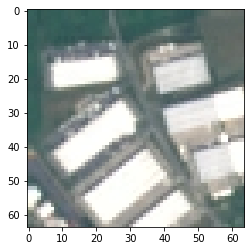

In [ ]:
plt.imshow(X_rgb[5])

## **2.3. Importing Multi-Spectral Data (13 Channels)**

While we are dealing with multi-spectral bands, there are 13 layers included in ".tif" file. 
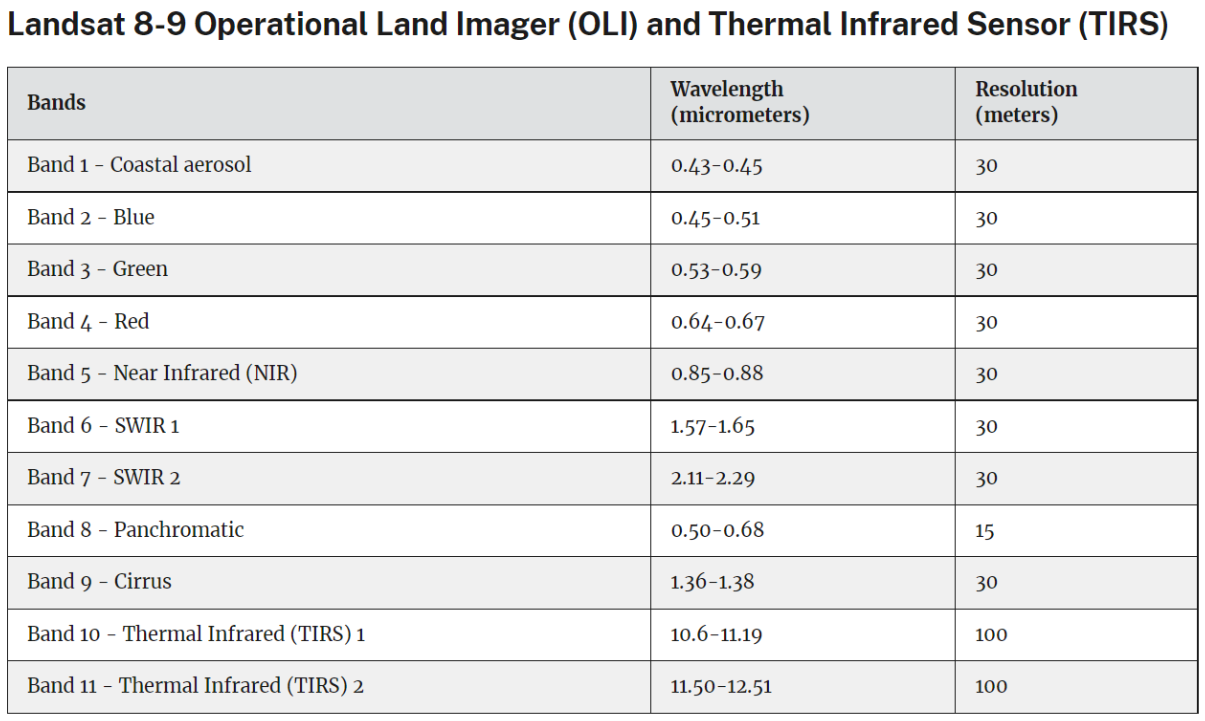


Below we can see that to access the true color for the related images acquired by Landsat-8, we can re-create a stacked array with using the bands 2, 3 and 4.

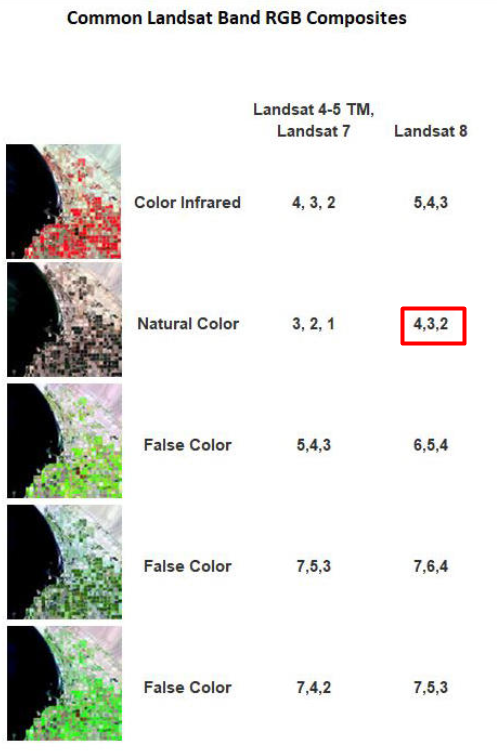

In [ ]:
drive.mount("/drive")

Mounted at /drive


In [ ]:
second_data_path = "/drive/MyDrive/Colab Notebooks/ds/images/remote_sensing/otherDatasets/sentinel_2/tif"

### **2.3.1. Data Normalization**

We normalize the data within the range of 0-1 by using the below function.

In [ ]:
def minmaxscaler(arr):
  return (arr - np.min(arr))/(np.max(arr)-np.min(arr))

In [ ]:
training_data = []
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(second_data_path, category)
        category_num = CATEGORIES.index(category)
        
        #According to RAM space, we only extract 1000 samples per category.
        count = 0
        
        for filename in os.listdir(path):
            try:
                
                img_array = rasterio.open(os.path.join(path,filename),driver="Gtiff").read()
                img_array = minmaxscaler(img_array)
                training_data.append([img_array,category_num])
                count +=1

            except Exception as e:
                pass
            
            if count == 1000:
                        break

create_training_data()

In [ ]:
training_data_b = []
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(second_data_path, category)
        category_num = CATEGORIES.index(category)
        
        #Test small data
        count = 0
        
        for filename in os.listdir(path):
            try:
                
                img_array = rasterio.open(os.path.join(path,filename),driver="Gtiff").read(2)
                img_array = minmaxscaler(img_array)
                training_data_b.append([img_array,category_num])
                count +=1

            except Exception as e:
                pass
            
            if count == 2:
                        break

create_training_data()

In [ ]:
training_data_g = []
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(second_data_path, category)
        category_num = CATEGORIES.index(category)
        
        #Test small data
        count = 0
        
        for filename in os.listdir(path):
            try:
                
                img_array = rasterio.open(os.path.join(path,filename),driver="Gtiff").read(3)
                img_array = minmaxscaler(img_array)
                training_data_g.append([img_array,category_num])
                count +=1

            except Exception as e:
                pass
            
            if count == 10:
                        break

create_training_data()

In [ ]:
training_data_r = []
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(second_data_path, category)
        category_num = CATEGORIES.index(category)
        
        #Test small data
        count = 0
        
        for filename in os.listdir(path):
            try:
                
                img_array = rasterio.open(os.path.join(path,filename),driver="Gtiff").read(4)
                img_array = minmaxscaler(img_array)
                training_data_r.append([img_array,category_num])
                count +=1

            except Exception as e:
                pass
            
            if count == 10:
                        break

create_training_data()

Sample image acquired by the related multi-spectral dataset with reading only one (1) band out of 13 bands.

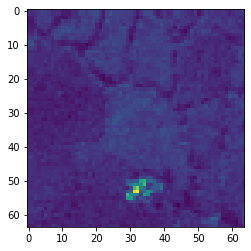

In [ ]:
plot.show(training_data_b[50][0])

In [ ]:
src = rasterio.open("/drive/MyDrive/Colab Notebooks/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/Highway/Highway_1.tif")

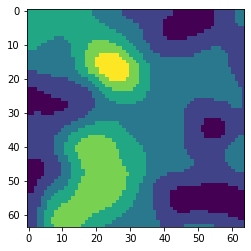

In [ ]:
plot.show(src.read(10))

In [ ]:
src_2 = rasterio.open("/drive/MyDrive/Colab Notebooks/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/Industrial/Industrial_1.tif")

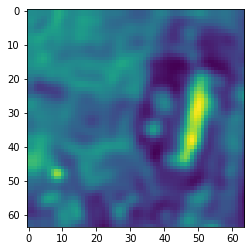

In [ ]:
plot.show(src_2.read(13))

### **2.3.2. Plotting True Color**

Sample image acquired by the related multi-spectral dataset with reading RGB bands.

In [ ]:
true_color = np.dstack((training_data_r[50][0],training_data_g[50][0],training_data_b[50][0]))

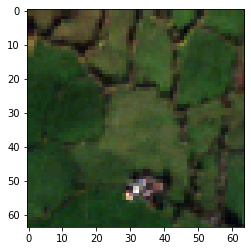

In [ ]:
plt.imshow(true_color)

We shuffle the related multi-spectral images, cause the classes may be sorted. Hence, we prevent "bias" issue of the model.

In [ ]:
random.shuffle(training_data)

Adding elements into the list:

- "X_ms" for the image features

- "y_ms" for the image category 

In [ ]:
X_ms = []
y_ms = []
for features, label in training_data:
    X_ms.append(features)
    y_ms.append(label)

Shape of X_ms for experiment data **1000 per each class**: 10000,13, 64, 64

Shape of y_ms for experiment data **1000 per each class**: 10000,

In [ ]:
np.shape(X_ms)

(8000, 13, 64, 64)

In [ ]:
np.shape(y_ms)

(8000,)

If needed necessary, reshape of data can be done below!

In [ ]:
#X_ms = np.array(X_ms).reshape(-1,64, 64, 1)
#y_ms = np.array(y_ms).reshape(-1,1)

### **2.3.3. Saving Extracted Multi-Spectral Data**

According the RGB data, extracting Multi-spectral data takes longer time. Therefore, we saved the related extracted data as a file in ".pickle" format.

#### **2.3.3.1. Writing**

In [ ]:
pickle_out = open("/drive/MyDrive/Colab Notebooks/X_ms.pickle","wb")
pickle.dump(X_ms,pickle_out)
pickle_out.close()

pickle_out = open("/drive/MyDrive/Colab Notebooks/y_ms.pickle","wb")
pickle.dump(y_ms,pickle_out)
pickle_out.close()

#### **2.3.3.2. Reading**

In [ ]:
pickle_in_X = open("/drive/MyDrive/Colab Notebooks/X_ms.pickle","rb")
pickle_in_y = open("/drive/MyDrive/Colab Notebooks/y_ms.pickle","rb")

#### **2.3.3.3. Loading**

In [ ]:
X_ms = pickle.load(pickle_in_X)
y_ms = pickle.load(pickle_in_y)

### **2.3.2. Splitting Multi-Spectral Data**

Dataset splits into:

*   Train
*   Valid
*   Test



In [ ]:
X_ms_train, X_ms_test, y_ms_train, y_ms_test = train_test_split(X_ms, y_ms, test_size=0.20, random_state=22)

In [ ]:
X_ms_train, X_ms_valid, y_ms_train, y_ms_valid = train_test_split(X_ms_train, y_ms_train, test_size=0.15, random_state=22)

# **3. Model**

## **3.1 Pre-Process**

### **3.1.2. Data Augmentation**

This section will be filled later, depending on model performance.

In [ ]:
"""
train_ms_generator = ImageDataGenerator(X_ms_train, y_ms_train,
                                        rotation = 45,
                                        horizontal_flip= True,
                                        vertical_flip = True
                                        )
"""

## **3.2. Model Architecture**

There will be three different model architectures experimented. These are listed below:
Training dataset with Multi-Layer Perceptron

1.   Training with MLP (Multi-layer Perceptron)
2.   Training with manually created CNN




### **3.2.1. Training Model With MLP**

#### **3.2.1.1. MLP Configuration - I**

#### **MLP - I Architecture**

This MLP architecure created without using regularizers. There are only 3 hidden layers included.

In [ ]:
model = Sequential();

#Input Layer
model.add(Flatten(input_shape = (13,64,64)))

#Hidden Layer without Regularizers
model.add(Dense(2000,activation='relu')) 

model.add(Dense(1000,activation='relu')) 

model.add(Dense(512,activation='relu')) 

#Output Layer
model.add(Dense(10,activation='softmax'))  # relu 4. layer

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 53248)             0         
                                                                 
 dense (Dense)               (None, 2000)              106498000 
                                                                 
 dense_1 (Dense)             (None, 1000)              2001000   
                                                                 
 dense_2 (Dense)             (None, 512)               512512    
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 109,016,642
Trainable params: 109,016,642
Non-trainable params: 0
_________________________________________________________________


#### **MLP - I Callbacks**

Earlystopper monitors validation accuracy ouputs of the model.

In [ ]:
earlystopper = EarlyStopping(monitor='val_accuracy',
                             patience=30,
                             mode='max',
                             restore_best_weights=True)

#### **MLP - I Compile**

MLP - I model compiled with SGD optimizer with a learning rate of 0.01.

In [ ]:
model.compile(optimizer=SGD(learning_rate=0.01),loss='sparse_categorical_crossentropy' ,metrics=['accuracy'])   

history = model.fit(np.array(X_ms_train),
                    np.array(y_ms_train),epochs = 100,
                    validation_data= (np.array(X_ms_valid),np.array(y_ms_valid)),
                    callbacks=earlystopper)

Epoch 1/100
170/170 [==============================] - 7s 25ms/step - loss: 1.7228 - accuracy: 0.3566 - val_loss: 1.4511 - val_accuracy: 0.5094
Epoch 2/100
170/170 [==============================] - 3s 16ms/step - loss: 1.4182 - accuracy: 0.4658 - val_loss: 1.3377 - val_accuracy: 0.5042
Epoch 3/100
170/170 [==============================] - 3s 17ms/step - loss: 1.3053 - accuracy: 0.5142 - val_loss: 1.3175 - val_accuracy: 0.5365
Epoch 4/100
170/170 [==============================] - 3s 17ms/step - loss: 1.2171 - accuracy: 0.5447 - val_loss: 1.1866 - val_accuracy: 0.5500
Epoch 5/100
170/170 [==============================] - 3s 17ms/step - loss: 1.1503 - accuracy: 0.5717 - val_loss: 1.1796 - val_accuracy: 0.5958
Epoch 6/100
170/170 [==============================] - 3s 16ms/step - loss: 1.1016 - accuracy: 0.5989 - val_loss: 1.1675 - val_accuracy: 0.5771
Epoch 7/100
170/170 [==============================] - 3s 15ms/step - loss: 1.0574 - accuracy: 0.6132 - val_loss: 1.2042 - val_accuracy:

#### **MLP - I Model Performance Graph**

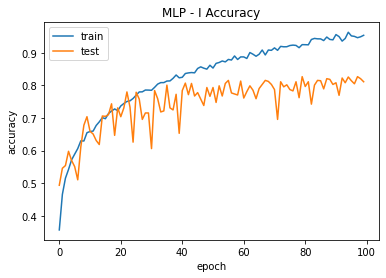

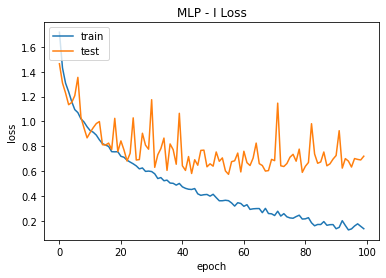

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MLP - I Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MLP - I Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### **MLP - I Model Performance Metrics**

In [ ]:
test_loss,test_acc = model.evaluate(np.array(X_ms_test),np.array(y_ms_test),verbose=2)

50/50 - 1s - loss: 0.6967 - accuracy: 0.8094 - 746ms/epoch - 15ms/step


#### **MLP - I Model Summary**

As we can see from the above graph, validation data is a bit noisy, hence we can assume there is some **overfitting** issue between the train data and test data. Therefore, we added regularizers into our **MLP - II** model.

#### **3.2.1.2. MLP Configuration - II**

#### **MLP - II Architecture**

This MLP architecure created with using both regularizers **dropout** and bias regularizer **l1_l2**.

In [ ]:
model = Sequential();

#Input Layer
model.add(Flatten(input_shape = (13,64,64)))  # 0 input layer

#Hidden Layers
model.add(Dense(2000,activation='relu', bias_regularizer=l1_l2()))  # relu layer 1.  #     kernel_regularizer=l1_l2(),bias_regularizer=l2()
model.add(Dropout(rate=0.5))

model.add(Dense(1000,activation='relu', bias_regularizer=l1_l2()))
model.add(Dropout(rate=0.5))

model.add(Dense(512,activation='relu', bias_regularizer=l1_l2()))

#Output Layer
model.add(Dense(10,activation='softmax'))  # relu 4. layer

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 53248)             0         
                                                                 
 dense_4 (Dense)             (None, 2000)              106498000 
                                                                 
 dropout (Dropout)           (None, 2000)              0         
                                                                 
 dense_5 (Dense)             (None, 1000)              2001000   
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               512512    
                                                                 
 dense_7 (Dense)             (None, 10)               

#### **MLP - II Callbacks**

In [ ]:
earlystopper = EarlyStopping(monitor='val_accuracy',
                             patience=25,
                             mode='max',
                             restore_best_weights=True)

#### **MLP - II Compile**

Regarding to the MLP - I model, we also updated the learning rate value from "**0.01**" to "**0.001**".

In [ ]:
model.compile(optimizer=SGD(learning_rate=0.001),loss='sparse_categorical_crossentropy' ,metrics=['accuracy'])   

history = model.fit(np.array(X_ms_train),
                    np.array(y_ms_train),epochs = 100,
                    validation_data= (np.array(X_ms_valid),np.array(y_ms_valid)),
                    callbacks=earlystopper)

Epoch 1/100
170/170 [==============================] - 6s 27ms/step - loss: 2.0453 - accuracy: 0.2478 - val_loss: 1.8004 - val_accuracy: 0.3167
Epoch 2/100
170/170 [==============================] - 3s 18ms/step - loss: 1.8304 - accuracy: 0.3164 - val_loss: 1.6508 - val_accuracy: 0.3729
Epoch 3/100
170/170 [==============================] - 3s 17ms/step - loss: 1.7356 - accuracy: 0.3574 - val_loss: 1.5846 - val_accuracy: 0.4302
Epoch 4/100
170/170 [==============================] - 3s 18ms/step - loss: 1.6659 - accuracy: 0.3875 - val_loss: 1.5093 - val_accuracy: 0.4573
Epoch 5/100
170/170 [==============================] - 3s 16ms/step - loss: 1.6137 - accuracy: 0.4035 - val_loss: 1.4763 - val_accuracy: 0.4500
Epoch 6/100
170/170 [==============================] - 3s 18ms/step - loss: 1.5642 - accuracy: 0.4072 - val_loss: 1.4116 - val_accuracy: 0.5052
Epoch 7/100
170/170 [==============================] - 3s 16ms/step - loss: 1.5223 - accuracy: 0.4318 - val_loss: 1.3813 - val_accuracy:

#### **MLP - II Model Performance Graph**

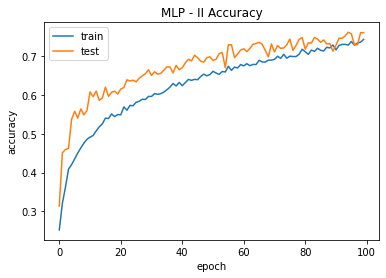

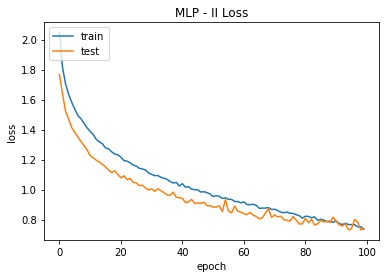

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MLP - II Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MLP - II Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### **MLP - II Model Performance Metrics**

In [ ]:
test_loss,test_acc = model.evaluate(np.array(X_ms_test),np.array(y_ms_test),verbose=2)

50/50 - 1s - loss: 0.7709 - accuracy: 0.7337 - 764ms/epoch - 15ms/step


#### **MLP - II Model Summary**

Both adding regularizers and decreasing the learning rate effected model performance positively, but there is one last tuning to be made, which is the epoch number.

As it can be seen from the above graph, there is some potential for increasing epoch number. Both training and validation losses still converging without violating our pre-determined "**Early Stopper**" rule. Next MLP configuration (*MLP - III in that case*), we will examine the affect of epoch number.

#### **3.2.1.3. MLP Configuration - III**

In this configuration MLP - III, we only updated the epoch number from 100 to 150.

#### **MLP - III Architecture**

In [ ]:
model = Sequential();

#Input Layer
model.add(Flatten(input_shape = (13,64,64)))  # 0 input layer

#Hidden Layers
model.add(Dense(2000,activation='relu', bias_regularizer=l1_l2()))  # relu layer 1.  #     kernel_regularizer=l1_l2(),bias_regularizer=l2()
model.add(Dropout(rate=0.5))

model.add(Dense(1000,activation='relu', bias_regularizer=l1_l2())) 
model.add(Dropout(rate=0.5))

model.add(Dense(512,activation='relu', bias_regularizer=l1_l2())) 

#Output Layer
model.add(Dense(10,activation='softmax'))  # relu 4. layer

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 53248)             0         
                                                                 
 dense (Dense)               (None, 2000)              106498000 
                                                                 
 dropout (Dropout)           (None, 2000)              0         
                                                                 
 dense_1 (Dense)             (None, 1000)              2001000   
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               512512    
                                                                 
 dense_3 (Dense)             (None, 10)                5

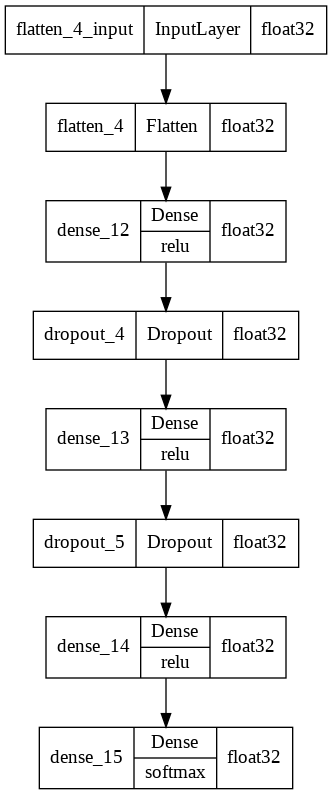

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='MLP_model.png',
    show_shapes=False,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

#### **MLP - III Callbacks**

In [ ]:
earlystopper = EarlyStopping(monitor='val_accuracy',
                             patience=25,
                             mode='max',
                             restore_best_weights=True)

#### **MLP - III Compile**

We increase the epoch number of the model from 100 to 150.

In [ ]:
model.compile(optimizer=SGD(learning_rate=0.001),loss='sparse_categorical_crossentropy' ,metrics=['accuracy'])   

history = model.fit(np.array(X_ms_train),
                    np.array(y_ms_train),epochs = 150,
                    validation_data= (np.array(X_ms_valid),np.array(y_ms_valid)),
                    callbacks=earlystopper)

Epoch 1/150
170/170 [==============================] - 7s 28ms/step - loss: 2.0532 - accuracy: 0.2502 - val_loss: 1.7519 - val_accuracy: 0.3323
Epoch 2/150
170/170 [==============================] - 3s 18ms/step - loss: 1.8166 - accuracy: 0.3333 - val_loss: 1.6092 - val_accuracy: 0.5417
Epoch 3/150
170/170 [==============================] - 3s 16ms/step - loss: 1.7220 - accuracy: 0.3671 - val_loss: 1.5376 - val_accuracy: 0.4990
Epoch 4/150
170/170 [==============================] - 3s 16ms/step - loss: 1.6405 - accuracy: 0.3952 - val_loss: 1.4795 - val_accuracy: 0.5010
Epoch 5/150
170/170 [==============================] - 3s 16ms/step - loss: 1.5808 - accuracy: 0.4226 - val_loss: 1.4297 - val_accuracy: 0.5156
Epoch 6/150
170/170 [==============================] - 3s 16ms/step - loss: 1.5555 - accuracy: 0.4318 - val_loss: 1.3881 - val_accuracy: 0.5135
Epoch 7/150
170/170 [==============================] - 3s 17ms/step - loss: 1.5070 - accuracy: 0.4502 - val_loss: 1.3564 - val_accuracy:

#### **MLP - III Model Performance Graph**

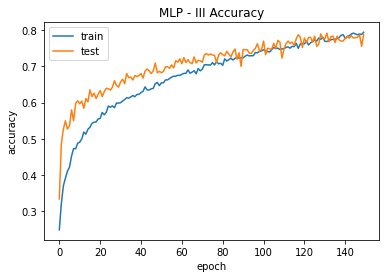

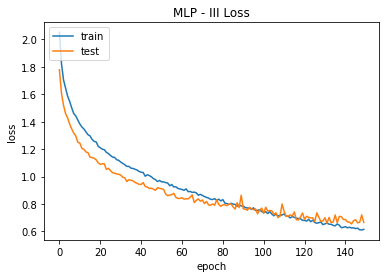

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MLP - III Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MLP - III Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### **MLP - III Model Performance Metrics**

In [ ]:
test_loss,test_acc = model.evaluate(np.array(X_ms_test),np.array(y_ms_test),verbose=2)

50/50 - 1s - loss: 0.7030 - accuracy: 0.7544 - 750ms/epoch - 15ms/step


#### **MLP - III Model Summary**

As we can see from the above graph, we handled the overfitting issue by adding regulizers into the related network.

### **3.2.2. Training Model With CNN**

#### **Data Formatting**

To train a CNN model we should be aware of the related data shapes. Below you can see the related data shapes for **train**, **validation** and **test**:



In [ ]:
X_ms_train = np.array(X_ms_train)
X_ms_train = np.reshape(X_ms_train,(-1,64,64,13))
y_ms_train = np.array(y_ms_train)

In [ ]:
print (X_ms_train.shape)
print (y_ms_train.shape)

(5440, 64, 64, 13)
(5440,)


In [ ]:
X_ms_valid = np.array(X_ms_valid)
X_ms_valid = np.reshape(X_ms_valid,(-1,64,64,13))
y_ms_valid = np.array(y_ms_valid)

In [ ]:
print (X_ms_valid.shape)
print (y_ms_valid.shape)

(960, 64, 64, 13)
(960,)


In [ ]:
X_ms_test = np.array(X_ms_test)
X_ms_test = np.reshape(X_ms_test,(-1,64,64,13))
y_ms_test = np.array(y_ms_test)

In [ ]:
print (X_ms_test.shape)
print (y_ms_test.shape)

(1600, 64, 64, 13)
(1600,)


#### **3.2.2.1. CNN Configuration - I**

#### **CNN - I Architecture**

This CNN architecture is created without using regularizers. The reason behind is, we should first test the model potential. Then we will pursue our network exploration by handling issues step by step. 

In [ ]:
model =  Sequential()

#Input Layer
model.add(Conv2D(32,kernel_size=3,padding='SAME',activation='relu',input_shape = (64, 64, 13) )) 
model.add(MaxPool2D(2,2))

model.add(Conv2D(32,kernel_size=3,padding='SAME', activation='relu' )) 
model.add(MaxPool2D(2,2))

#Second Layer
model.add(Conv2D(64,kernel_size=3,padding='SAME',activation='relu' )) 
model.add(MaxPool2D(2,2))

model.add(Conv2D(64,kernel_size=3,padding='SAME',activation='relu' )) 
model.add(MaxPool2D(2,2))

model.add(Conv2D(128,kernel_size=3,padding='SAME',activation='relu' )) 
model.add(MaxPool2D(2,2))

model.add(Conv2D(256,kernel_size=3,padding='SAME',activation='relu' )) 
model.add(MaxPool2D(2,2))

#Fully Connected Network
model.add(Flatten())
model.add(Dense(256,activation='relu'))

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu')
)
#Output Layer
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        3776      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0

#### **CNN - I Callbacks**

Our earlystopper rule monitors validation accuracy output.

In [ ]:
earlystopper = EarlyStopping(monitor='val_accuracy',
                             patience=35,
                             mode='max',
                             restore_best_weights=True)

#### **CNN - I Compile**

At first we prefer to use **SGD** as an optimizer, but later configuration we will discuss the usage of **Adam** optimizer also, please continue reading.

In [ ]:
model.compile(optimizer=SGD(learning_rate=0.01),loss='sparse_categorical_crossentropy' ,metrics=['accuracy'])

history = model.fit(X_ms_train,
                    y_ms_train,
                    validation_data= (X_ms_valid,y_ms_valid),
                    callbacks=earlystopper,
                    epochs=200)   

Epoch 1/200
170/170 [==============================] - 14s 19ms/step - loss: 2.2820 - accuracy: 0.1822 - val_loss: 2.2474 - val_accuracy: 0.2031
Epoch 2/200
170/170 [==============================] - 2s 10ms/step - loss: 1.9647 - accuracy: 0.2993 - val_loss: 1.7438 - val_accuracy: 0.3271
Epoch 3/200
170/170 [==============================] - 2s 10ms/step - loss: 1.6130 - accuracy: 0.3783 - val_loss: 1.5350 - val_accuracy: 0.4542
Epoch 4/200
170/170 [==============================] - 2s 10ms/step - loss: 1.4899 - accuracy: 0.4419 - val_loss: 1.3916 - val_accuracy: 0.5188
Epoch 5/200
170/170 [==============================] - 2s 11ms/step - loss: 1.4229 - accuracy: 0.4574 - val_loss: 1.3642 - val_accuracy: 0.4667
Epoch 6/200
170/170 [==============================] - 2s 10ms/step - loss: 1.3548 - accuracy: 0.4866 - val_loss: 1.2770 - val_accuracy: 0.5875
Epoch 7/200
170/170 [==============================] - 2s 10ms/step - loss: 1.2880 - accuracy: 0.5226 - val_loss: 1.1239 - val_accuracy

#### CNN - I Model Performance Graph

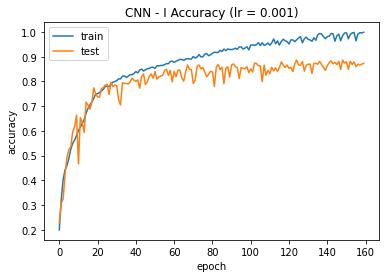

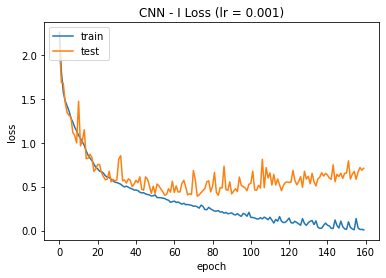

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN - I Accuracy (lr = 0.001)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN - I Loss (lr = 0.001)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### CNN - I Model Performance Metrics

In [ ]:
test_loss,test_acc = model.evaluate(np.array(X_ms_test),np.array(y_ms_test),verbose=2)

50/50 - 0s - loss: 0.4992 - accuracy: 0.8737 - 473ms/epoch - 9ms/step


#### CNN - I Model Summary

By using CNN we observed much better accuracy and much better loss value closer to zero. But on the other hand as we can see from the above plot, our model is issued with overfitting problem. To handle this issue we introduced regulizers into our network on configuration II (CNN-II).

#### 3.2.2.2. CNN Configuration - II

#### CNN - II Architecture

In configuration II, to handle overfitting issue, we added dropout layers into the network architecture.

In [ ]:
model =  Sequential()

#Input Layer
model.add(Conv2D(32,kernel_size=3,padding='SAME',activation='relu',input_shape = (64, 64, 13) )) 
model.add(MaxPool2D(2,2))
model.add(Dropout(0.5))
#First Layer
model.add(Conv2D(32,kernel_size=3,padding='SAME', activation='relu' )) 


#Second Layer
model.add(Conv2D(64,kernel_size=3,padding='SAME',activation='relu' )) 
model.add(MaxPool2D(2,2))
model.add(Dropout(0.5))

#Third Layer
model.add(Conv2D(64,kernel_size=3,padding='SAME',activation='relu' )) 


#Forth Layer
model.add(Conv2D(128,kernel_size=3,padding='SAME',activation='relu' )) 
model.add(MaxPool2D(2,2))
model.add(Dropout(0.5))

#Fifth Layer
model.add(Conv2D(256,kernel_size=3,padding='SAME',activation='relu' )) 


#Fully Connected Network
model.add(Flatten())
model.add(Dense(256,activation='relu'))

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu')
)
#Output Layer
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        3776      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                    

#### CNN - II Callbacks

In [ ]:
earlystopper = EarlyStopping(monitor='val_accuracy',
                             patience=35,
                             mode='max',
                             restore_best_weights=True)

#### CNN - II Compile

In [ ]:
model.compile(optimizer=SGD(learning_rate=0.01),loss='sparse_categorical_crossentropy' ,metrics=['accuracy'])

history = model.fit(X_ms_train,
                    y_ms_train,
                    validation_data= (X_ms_valid, y_ms_valid),
                    callbacks=earlystopper,
                    epochs=200)   

Epoch 1/200
170/170 [==============================] - 14s 18ms/step - loss: 2.1285 - accuracy: 0.1912 - val_loss: 1.9500 - val_accuracy: 0.2583
Epoch 2/200
170/170 [==============================] - 2s 13ms/step - loss: 1.7403 - accuracy: 0.3371 - val_loss: 1.7030 - val_accuracy: 0.4083
Epoch 3/200
170/170 [==============================] - 2s 13ms/step - loss: 1.6066 - accuracy: 0.3877 - val_loss: 1.6777 - val_accuracy: 0.4437
Epoch 4/200
170/170 [==============================] - 2s 13ms/step - loss: 1.5192 - accuracy: 0.4230 - val_loss: 1.6107 - val_accuracy: 0.3958
Epoch 5/200
170/170 [==============================] - 2s 13ms/step - loss: 1.4629 - accuracy: 0.4465 - val_loss: 1.5654 - val_accuracy: 0.4604
Epoch 6/200
170/170 [==============================] - 2s 13ms/step - loss: 1.4228 - accuracy: 0.4647 - val_loss: 1.4539 - val_accuracy: 0.4646
Epoch 7/200
170/170 [==============================] - 2s 13ms/step - loss: 1.3738 - accuracy: 0.4779 - val_loss: 1.4300 - val_accuracy

#### CNN - II Model Performance Graph

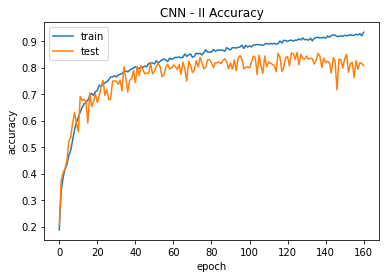

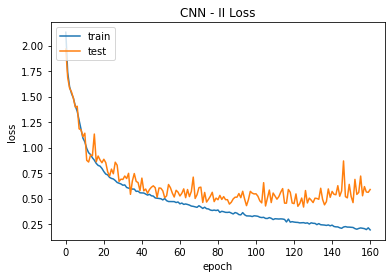

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN - II Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN - II Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### CNN - II Model Performance Metrics

In [ ]:
test_loss,test_acc = model.evaluate(np.array(X_ms_test),np.array(y_ms_test),verbose=2)

50/50 - 1s - loss: 8.0187 - accuracy: 0.0969 - 519ms/epoch - 10ms/step


#### 3.2.2.3. CNN Configuration - III

#### CNN - III Architecture

In [ ]:
model =  Sequential()

#Input Layer
model.add(Conv2D(32,kernel_size=3,padding='SAME',activation='relu',input_shape = (64, 64, 13) )) 
model.add(MaxPool2D(2,2))
model.add(Dropout(0.5))

#First Layer
model.add(Conv2D(32,kernel_size=3,padding='SAME', activation='relu',kernel_regularizer=l1_l2())) 


#Second Layer
model.add(Conv2D(64,kernel_size=3,padding='SAME',activation='relu')) 
model.add(MaxPool2D(2,2))
model.add(Dropout(0.5))

#Third Layer
model.add(Conv2D(64,kernel_size=3,padding='SAME',activation='relu',kernel_regularizer=l1_l2() )) 


#Forth Layer
model.add(Conv2D(128,kernel_size=3,padding='SAME',activation='relu' )) 
model.add(MaxPool2D(2,2))
model.add(Dropout(0.5))

#Fifth Layer
model.add(Conv2D(256,kernel_size=3,padding='SAME',activation='relu' )) 


#Fully Connected Network
model.add(Flatten())
model.add(Dense(256,activation='relu'))

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu')
)
#Output Layer
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        3776      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                    

#### CNN - III Callbacks

In [ ]:
earlystopper = EarlyStopping(monitor='val_accuracy',
                             patience=35,
                             mode='max',
                             restore_best_weights=True)

#### CNN - III Compile

In [ ]:
model.compile(optimizer=SGD(learning_rate=0.01),loss='sparse_categorical_crossentropy' ,metrics=['accuracy'])

history = model.fit(X_ms_train,
                    y_ms_train,
                    validation_data= (X_ms_valid, y_ms_valid),
                    callbacks=earlystopper,
                    epochs=200)   

Epoch 1/200
170/170 [==============================] - 15s 25ms/step - loss: 16.9309 - accuracy: 0.2338 - val_loss: 12.9122 - val_accuracy: 0.2833
Epoch 2/200
170/170 [==============================] - 3s 19ms/step - loss: 9.7539 - accuracy: 0.3469 - val_loss: 7.0553 - val_accuracy: 0.3604
Epoch 3/200
170/170 [==============================] - 3s 18ms/step - loss: 5.0555 - accuracy: 0.3914 - val_loss: 3.4355 - val_accuracy: 0.4177
Epoch 4/200
170/170 [==============================] - 3s 17ms/step - loss: 2.5956 - accuracy: 0.4028 - val_loss: 2.1060 - val_accuracy: 0.3823
Epoch 5/200
170/170 [==============================] - 2s 14ms/step - loss: 1.8444 - accuracy: 0.4336 - val_loss: 1.7365 - val_accuracy: 0.4219
Epoch 6/200
170/170 [==============================] - 2s 13ms/step - loss: 1.6459 - accuracy: 0.4307 - val_loss: 1.5101 - val_accuracy: 0.5010
Epoch 7/200
170/170 [==============================] - 2s 13ms/step - loss: 1.5913 - accuracy: 0.4458 - val_loss: 1.5111 - val_accura

KeyboardInterrupt: ignored

#### CNN - III Model Performance Graph

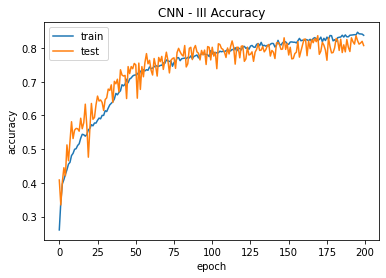

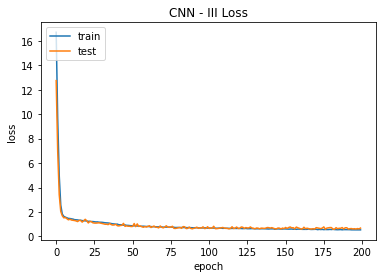

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN - III Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN - III Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### CNN - III Model Performance Metrics

In [ ]:
test_loss,test_acc = model.evaluate(np.array(X_ms_test),np.array(y_ms_test),verbose=2)

#### 3.2.2.4. CNN Configuration - IV

#### CNN - IV Architecture

In [ ]:
model =  Sequential()

#Input Layer
model.add(Conv2D(32,kernel_size=3,padding='SAME',activation='relu',input_shape = (64, 64, 13) )) 
model.add(MaxPool2D(2,2))


#First Layer
model.add(Conv2D(32,kernel_size=3,padding='SAME', activation='relu')) 

#Second Layer
model.add(Conv2D(64,kernel_size=3,padding='SAME',activation='relu',kernel_regularizer=l1_l2())) 
model.add(MaxPool2D(2,2))
model.add(Dropout(0.5))


#Third Layer
model.add(Conv2D(64,kernel_size=3,padding='SAME',activation='relu',kernel_regularizer=l1_l2())) 


#Forth Layer
model.add(Conv2D(128,kernel_size=3,padding='SAME',activation='relu',kernel_regularizer=l1_l2() )) 
model.add(MaxPool2D(2,2))
model.add(Dropout(0.5))


#Fifth Layer
model.add(Conv2D(256,kernel_size=3,padding='SAME',activation='relu' )) 


#Fully Connected Network
model.add(Flatten())
model.add(Dense(256,activation='relu'))

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu')
)
#Output Layer
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        3776      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0

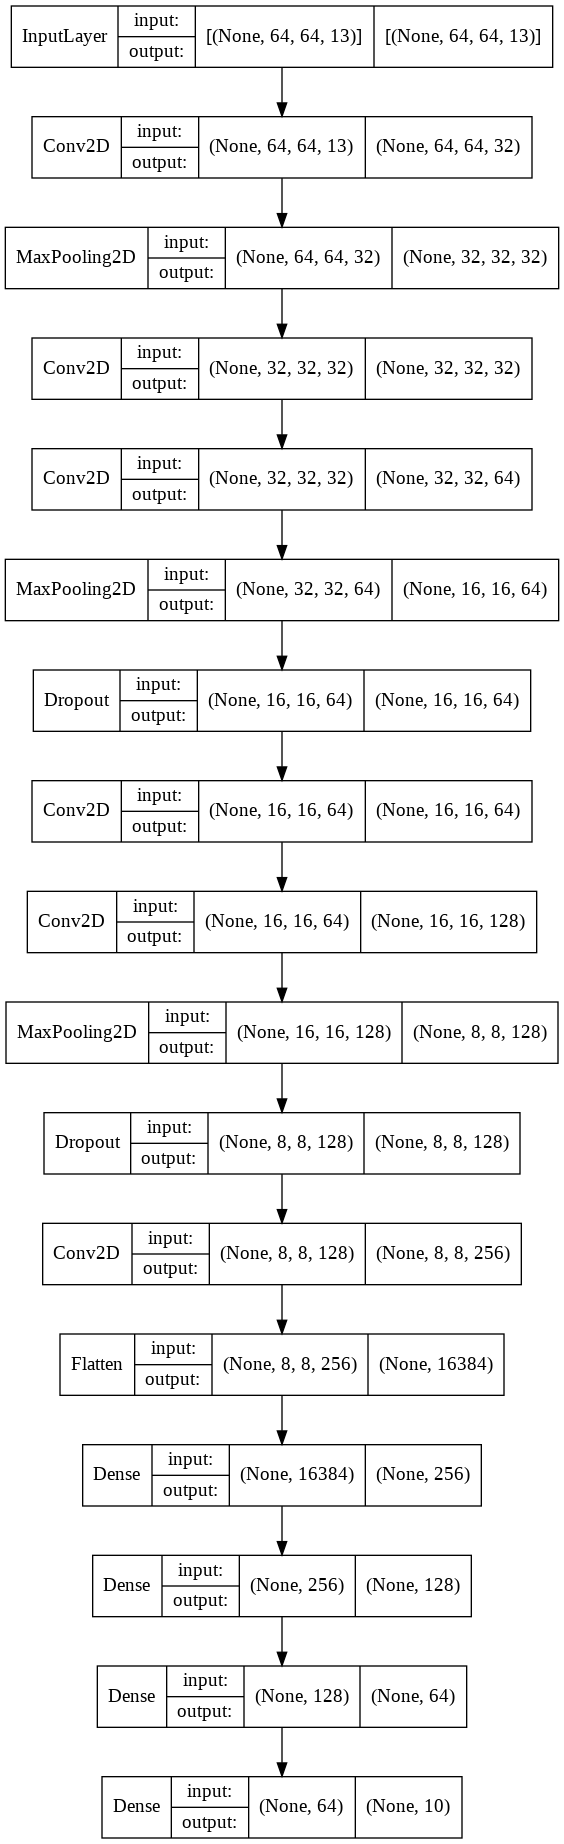

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='CNN_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

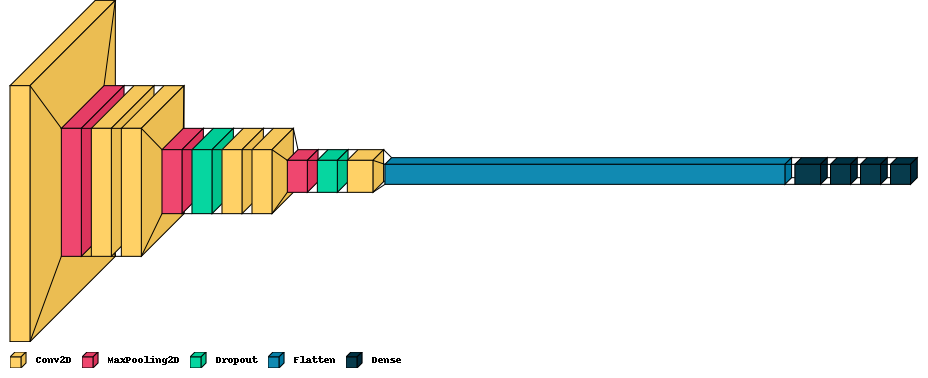

In [ ]:
visualkeras.layered_view(model, legend=True) 

#### CNN - IV Callbacks

In [ ]:
earlystopper = EarlyStopping(monitor='val_accuracy',
                             patience=20,
                             mode='max',
                             restore_best_weights=True)

#### CNN - IV Compile

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0005),loss='sparse_categorical_crossentropy' ,metrics=['accuracy'])

history = model.fit(X_ms_train,
                    y_ms_train,
                    validation_data= (X_ms_valid, y_ms_valid),
                    callbacks=earlystopper,
                    epochs=100)   

Epoch 1/100
170/170 [==============================] - 15s 21ms/step - loss: 14.1309 - accuracy: 0.3221 - val_loss: 1.7848 - val_accuracy: 0.4833
Epoch 2/100
170/170 [==============================] - 2s 13ms/step - loss: 1.6501 - accuracy: 0.4577 - val_loss: 1.5739 - val_accuracy: 0.4781
Epoch 3/100
170/170 [==============================] - 2s 13ms/step - loss: 1.4880 - accuracy: 0.5064 - val_loss: 1.3821 - val_accuracy: 0.5833
Epoch 4/100
170/170 [==============================] - 2s 13ms/step - loss: 1.3857 - accuracy: 0.5553 - val_loss: 1.3602 - val_accuracy: 0.5594
Epoch 5/100
170/170 [==============================] - 2s 13ms/step - loss: 1.3294 - accuracy: 0.5704 - val_loss: 1.1973 - val_accuracy: 0.6490
Epoch 6/100
170/170 [==============================] - 2s 13ms/step - loss: 1.2367 - accuracy: 0.6059 - val_loss: 1.1707 - val_accuracy: 0.6406
Epoch 7/100
170/170 [==============================] - 2s 14ms/step - loss: 1.1953 - accuracy: 0.6184 - val_loss: 1.0759 - val_accurac

#### CNN - IV Model Performance Graph

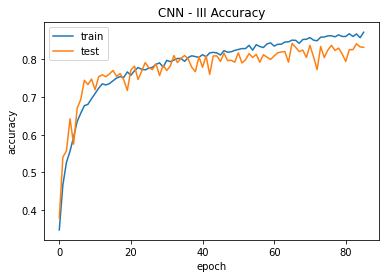

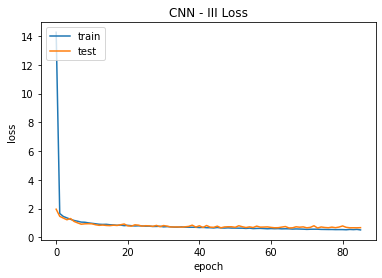

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN - III Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN - III Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### CNN - IV Performance Metrics

In [ ]:
test_loss,test_acc = model.evaluate(np.array(X_ms_test),np.array(y_ms_test),verbose=2)

50/50 - 1s - loss: 0.6661 - accuracy: 0.8175 - 657ms/epoch - 13ms/step


#### CNN - IV Model Summary

In this model we handle the overfitting issue by adding regularizers. We tried to add batch normalizations for the layers but, it ended up making mode overfitting. Additionally, by concerning overshooting problems, we changed our optimizer to Adam and decreased learning rate from 0.01 to 0.0005. Where we ended up an ideal tuned CNN model.